<a href="https://colab.research.google.com/github/anmatrapazis/FashionMNIST-MLP-CNN/blob/main/FMNIST_MLP_Matrapazis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Libraries


In [2]:
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

In [3]:
pip install keras-tuner --upgrade

     |████████████████████████████████| 102kB 11.6MB/s 
  Created wheel for kt-legacy: filename=kt_legacy-1.0.3-cp37-none-any.whl size=9569 sha256=add9bb0c0b37fe5175e0f21158705df613bd8e9329aeb0ec69e4ba71d5601483
  Stored in directory: /root/.cache/pip/wheels/95/99/a8/6b116b0f69be60cc475d1cd36680f3a09f284d86655bb99d93
Successfully built kt-legacy


In [4]:
import gc
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
from tensorflow.keras import layers


from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.random import set_seed
from tensorflow.keras.models import Model # The class used to create a model
from keras.callbacks import EarlyStopping

from kerastuner.tuners import RandomSearch
from tensorflow.keras.layers import Input, Dense,Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization

#from tensorflow.keras.layers import Input



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


## Load data

> as [tensorflow fashion_mnist](https://www.tensorflow.org/tutorials/keras/classification) shows

In [5]:
(x_train,y_train),(x_test,y_test)=fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [6]:
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train, test_size = 0.2, random_state = 42)

In [7]:
print('Fashion MNIST Dataset Shape:')
print('x_train: ', x_train.shape)
print('y_train: ', y_train.shape)
print('x_val:  ', x_val.shape)
print('y_val:  ', y_val.shape)
print('x_test:  ', x_test.shape)
print('y_test:  ', y_test.shape)


Fashion MNIST Dataset Shape:
x_train:  (48000, 28, 28)
y_train:  (48000,)
x_val:   (12000, 28, 28)
y_val:   (12000,)
x_test:   (10000, 28, 28)
y_test:   (10000,)


In [8]:
labels = {0:"T-shirt/top",
          1:"Trouser",
          2:"Pullover",
          3:"Dress",
          4:"Coat",
          5:"Sandal",
          6:"Shirt",
          7:"Sneaker",
          8:"Bag",
          9:"Ankle boot"
}

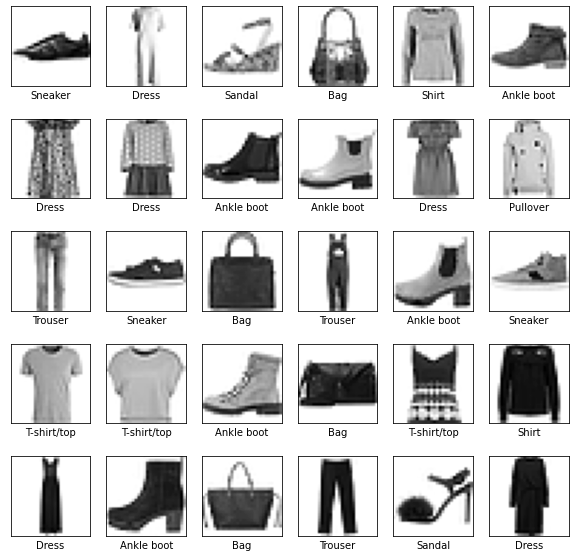

In [9]:
plt.figure(figsize=(10,10))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(labels[y_train[i]])
plt.show()

## Preprocess for Sequential MLP

In [10]:
x_train = x_train/255
x_val = x_val/255
x_test = x_test/255
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# Sequential MLP

1. How many hidden layers?
2. Ho many numbers of neurons?
3. Learning Rate?

In [11]:
np.random.seed(1402) # Define the seed for numpy to have reproducible experiments.
set_seed(1981) # Define the seed for Tensorflow to have reproducible experiments.

In [12]:

def build_model(hp):
  model = keras.Sequential()
  model.add(Flatten(input_shape = (28,28))) #flattening the image
  model.add(Dropout(hp.Float('dropout', min_value = 0, max_value = 0.3, step=0.1)))
  for i in range(hp.Int('num_layers',1,4)):
    model.add(Dense(units = hp.Choice('hidden_units '+str(i), [512,256,128,64,32]), 
                    activation='relu'))

    model.add(Dropout(hp.Float('dropout_hidden '+str(i), min_value = 0, max_value = 0.4,step=0.1)))
  model.add(Dense(10, activation='softmax'))

  hp_learning_rate = hp.Choice('learning_rate', [1e-2,1e-3])

  optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate)  

  model.compile(
      optimizer = optimizer,
      loss = 'categorical_crossentropy',
      metrics = ['accuracy']
  )
  return model

> In general, I noticed during the tuning process that a model that goes from general to specific (more hidden units at the first hidden layers, less hidden units at the last hidden layers) has better performance that the models that follows specific to general pattern.

In [13]:
tuner = RandomSearch(
    build_model,
    objective = 'val_loss',
    max_trials = 5,
    executions_per_trial=2, 
    directory = 'my_dir_mlp',
    project_name = 'mlp_adam')

In [14]:
es = EarlyStopping(monitor='val_accuracy', mode = 'max', patience = 5)
with tf.device('/device:GPU:0'):
  tuner.search(x_train, y_train,
              epochs=50,
              validation_data=(x_val, y_val), 
              callbacks=[es])


Trial 5 Complete [00h 02m 48s]
val_loss: 0.6443357169628143

Best val_loss So Far: 0.31290239095687866
Total elapsed time: 00h 30m 06s
INFO:tensorflow:Oracle triggered exit


In [15]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=3)[0]
tuner.results_summary()

Results summary
Results in my_dir_mlp/mlp_adam
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
dropout: 0.2
num_layers: 2
hidden_units 0: 256
dropout_hidden 0: 0.30000000000000004
learning_rate: 0.001
hidden_units 1: 512
dropout_hidden 1: 0.2
hidden_units 2: 32
dropout_hidden 2: 0.30000000000000004
Score: 0.31290239095687866
Trial summary
Hyperparameters:
dropout: 0.30000000000000004
num_layers: 1
hidden_units 0: 32
dropout_hidden 0: 0.30000000000000004
learning_rate: 0.001
hidden_units 1: 256
dropout_hidden 1: 0.1
hidden_units 2: 32
dropout_hidden 2: 0.1
Score: 0.37453489005565643
Trial summary
Hyperparameters:
dropout: 0.2
num_layers: 1
hidden_units 0: 512
dropout_hidden 0: 0.0
learning_rate: 0.01
hidden_units 1: 512
dropout_hidden 1: 0.2
hidden_units 2: 64
dropout_hidden 2: 0.1
Score: 0.42171573638916016
Trial summary
Hyperparameters:
dropout: 0.2
num_layers: 2
hidden_units 0: 32
dropout_hidden 0: 0.30000000000000004
learning_rate: 0

In [16]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
# Early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max',patience=10, verbose=1)
#History
with tf.device('/device:GPU:0'):
  history = model.fit(
        x_train, 
        y_train,
        validation_data=(x_val, y_val),
        batch_size=8192,
        epochs=250,
        shuffle=True,
        callbacks=[es]
        )

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/250
6/6 [==============================] - 4s 493ms/step - loss: 1.7986 - accuracy: 0.3985 - val_loss: 1.0311 - val_accuracy: 0.6614
Epoch 2/250
6/6 [==============================] - 3s 447ms/step - loss: 0.9978 - accuracy: 0.6376 - val_loss: 0.7578 - val_accuracy: 0.7138
Epoch 3/250
6/6 [==============================] - 3s 452ms/step - loss: 0.8236 - accuracy: 0.6990 - val_loss: 0.6664 - val_accuracy: 0.7585
Epoch 4/250
6/6 [==============================] - 3s 452ms/step - loss: 0.7148 - accuracy: 0.7396 - val_loss: 0.6018 - val_accuracy: 0.7797
Epoch 5/250
6/6 [==============================] - 3s 451ms/step - loss: 0.6426 - accuracy: 0.7662 - val_loss: 0.5562 - val_accuracy: 0.7997
Epoch 6/250
6/6 [==============================] - 3s 451ms/step - loss: 0.5999 - accuracy: 0.7843 - val_loss: 0.5218 - val_accuracy: 0.8134
Epoch 7/250
6/6 [==============================] - 3s 450ms/step - loss: 0.5667 - accuracy: 0.7985 - val_loss: 0.5012 - val_accuracy: 0.8189
Epoch 8/250
6

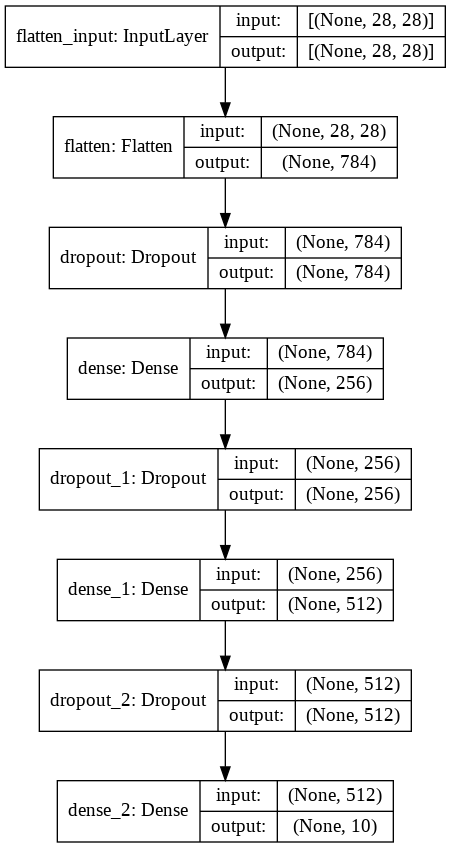

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True)

### curves

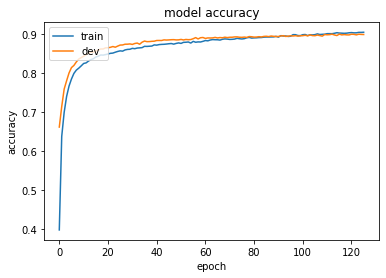

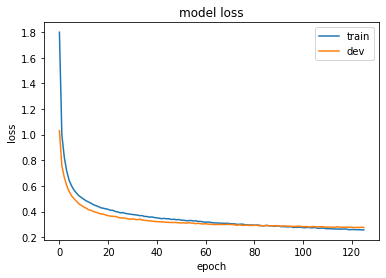

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

In [19]:
from sklearn.metrics import classification_report

#MLP on training set
train_pred = np.round(model.predict(x_train))
print('Training Set:')
print(classification_report(y_train, train_pred))
print('=======================================================')

#MLP on validation set
val_pred = np.round(model.predict(x_val))
print('Validation Set:')
print(classification_report(y_val, val_pred))
print('=======================================================')


#MLP on test set
test_pred = np.round(model.predict(x_test))
print('Test Set:')
print(classification_report(y_test, test_pred))

Training Set:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      4798
           1       1.00      0.99      0.99      4781
           2       0.92      0.80      0.86      4795
           3       0.97      0.91      0.94      4816
           4       0.84      0.88      0.86      4798
           5       1.00      0.99      0.99      4789
           6       0.87      0.75      0.81      4782
           7       0.97      0.98      0.98      4841
           8       1.00      0.99      0.99      4803
           9       0.98      0.98      0.98      4797

   micro avg       0.95      0.92      0.93     48000
   macro avg       0.94      0.92      0.93     48000
weighted avg       0.94      0.92      0.93     48000
 samples avg       0.92      0.92      0.92     48000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Set:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1202
           1       0.99      0.97      0.98      1219
           2       0.90      0.76      0.83      1205
           3       0.93      0.87      0.90      1184
           4       0.81      0.85      0.83      1202
           5       0.98      0.96      0.97      1211
           6       0.81      0.66      0.73      1218
           7       0.95      0.96      0.95      1159
           8       0.99      0.96      0.97      1197
           9       0.95      0.97      0.96      1203

   micro avg       0.92      0.88      0.90     12000
   macro avg       0.91      0.88      0.90     12000
weighted avg       0.91      0.88      0.90     12000
 samples avg       0.88      0.88      0.88     12000

Test Set:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1000
           1       0.99      0.97      0.98      100

# CNN

In [11]:
train_images = x_train.reshape(len(x_train), 28, 28, 1)
val_images = x_val.reshape(len(x_val), 28, 28, 1)
test_images = x_test.reshape(len(x_test), 28, 28, 1)

In [12]:
def build_model_cnn(hp):

  model = keras.Sequential()
  model.add(Conv2D(filters = hp.Int('conv_1_filter',min_value = 32,max_value = 256,step = 32),
                   kernel_size = hp.Choice('conv_1_kernel',values = [3,5]),
                   activation = 'relu',
                   input_shape = (28,28,1)))
           
  model.add(MaxPooling2D(pool_size=(2, 2)))

  for i in range(hp.Int('hidden_layers',1,4)):
    model.add(Conv2D(filters = hp.Int('conv_'+str(i)+'_filter ',min_value = 32,max_value = 256,step = 32),
                   kernel_size = hp.Choice('conv_'+str(i)+'_kernel ',values = [3,5]),
                   activation = 'relu',
                   input_shape = (28,28,1)))
  
  model.add(Flatten())
  model.add(Dense(10))
  model.add(Activation('softmax'))

  hp_learning_rate = hp.Choice('learning_rate', [1e-2,1e-3])
  optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate)
  
  model.compile(
      optimizer = optimizer,
      loss = 'categorical_crossentropy',
      metrics = ['accuracy']
  )

  return model

In [22]:
# With dropouts
def build_model_cnn(hp):

  model = keras.Sequential()
  model.add(Conv2D(filters = hp.Int('conv_1_filter',min_value = 32,max_value = 256,step = 32),
                   kernel_size = hp.Choice('conv_1_kernel',values = [3,5]),
                   activation = 'relu',
                   input_shape = (28,28,1)))
           
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(hp.Float('dropout_hidden ', min_value = 0, max_value = 0.3,step=0.1)))

  for i in range(hp.Int('hidden_layers',1,4)):
    model.add(Conv2D(filters = hp.Int('hidden_ conv_'+str(i)+'_filter ',min_value = 32,max_value = 256,step = 32),
                   kernel_size = hp.Choice('hidden_conv_'+str(i)+'_kernel ',values = [3,5]),
                   activation = 'relu',
                   input_shape = (28,28,1)))
    model.add(Dropout(hp.Float('dropout_hidden '+str(i), min_value = 0, max_value = 0.4,step=0.1)))
  
  model.add(Flatten())
  model.add(Dense(10))
  model.add(Activation('softmax'))

  hp_learning_rate = hp.Choice('learning_rate', [1e-2,1e-3])
  optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate)
  
  model.compile(
      optimizer = optimizer,
      loss = 'categorical_crossentropy',
      metrics = ['accuracy']
  )

  return model


In [13]:
tuner_cnn = RandomSearch(
    build_model_cnn,
    objective = 'val_loss',
    max_trials = 5,
    directory = 'my_dir_cnn',
    project_name = 'fmnist_cnn')

In [14]:
es = EarlyStopping(monitor='val_accuracy',mode = 'max', patience = 5)
with tf.device('/device:GPU:0'):
  tuner_cnn.search(train_images, y_train,
              epochs=50,
              validation_data=(val_images, y_val), 
              callbacks=[es])

Trial 5 Complete [00h 02m 16s]
val_loss: 0.34914281964302063

Best val_loss So Far: 0.2597511112689972
Total elapsed time: 00h 10m 18s
INFO:tensorflow:Oracle triggered exit


In [15]:
# Get the optimal hyperparameters
best_hps_cnn=tuner_cnn.get_best_hyperparameters(num_trials=2)[0]

In [16]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner_cnn.hypermodel.build(best_hps_cnn)
# Early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max',patience=10, verbose=1)
#History
with tf.device('/device:GPU:0'):
  history = model.fit(
        train_images, 
        y_train,
        validation_data=(val_images, y_val),
        batch_size=8192,
        epochs=250,
        shuffle=True,
        callbacks=[es]
        )

Epoch 1/250
6/6 [==============================] - 16s 2s/step - loss: 2.0623 - accuracy: 0.3699 - val_loss: 1.7761 - val_accuracy: 0.3626
Epoch 2/250
6/6 [==============================] - 2s 360ms/step - loss: 1.5186 - accuracy: 0.4517 - val_loss: 1.1950 - val_accuracy: 0.5314
Epoch 3/250
6/6 [==============================] - 2s 356ms/step - loss: 1.0730 - accuracy: 0.6066 - val_loss: 0.9472 - val_accuracy: 0.6511
Epoch 4/250
6/6 [==============================] - 2s 366ms/step - loss: 0.8964 - accuracy: 0.6722 - val_loss: 0.8475 - val_accuracy: 0.6874
Epoch 5/250
6/6 [==============================] - 2s 368ms/step - loss: 0.8174 - accuracy: 0.7016 - val_loss: 0.7757 - val_accuracy: 0.7174
Epoch 6/250
6/6 [==============================] - 2s 373ms/step - loss: 0.7479 - accuracy: 0.7226 - val_loss: 0.7156 - val_accuracy: 0.7386
Epoch 7/250
6/6 [==============================] - 2s 374ms/step - loss: 0.6963 - accuracy: 0.7404 - val_loss: 0.6684 - val_accuracy: 0.7473
Epoch 8/250
6/6

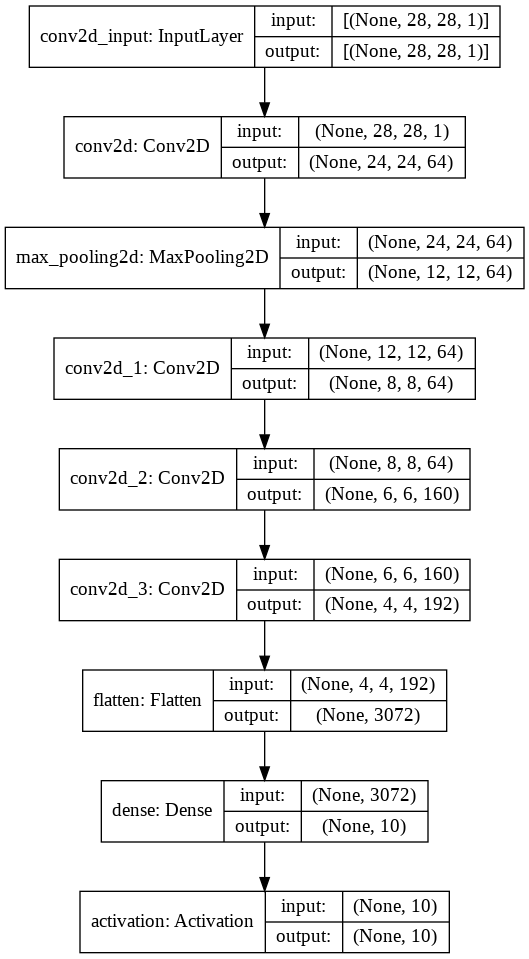

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True)

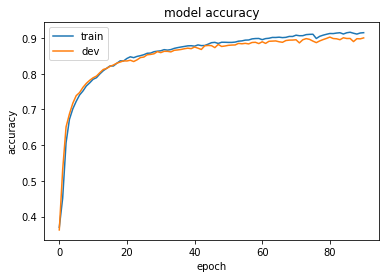

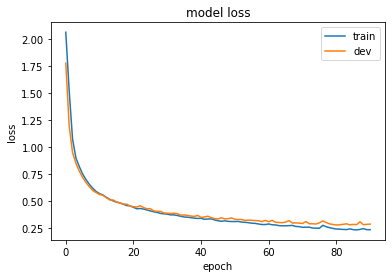

In [18]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

In [19]:
from sklearn.metrics import classification_report

#MLP on training set
train_pred = np.round(model.predict(train_images))
print('Training Set:')
print(classification_report(y_train, train_pred))
print('=======================================================')

#MLP on validation set
val_pred = np.round(model.predict(val_images))
print('Validation Set:')
print(classification_report(y_val, val_pred))
print('=======================================================')

#MLP on test set
test_pred = np.round(model.predict(test_images))
print('Test Set:')
print(classification_report(y_test, test_pred))

Training Set:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      4798
           1       0.99      0.99      0.99      4781
           2       0.89      0.84      0.87      4795
           3       0.92      0.93      0.93      4816
           4       0.90      0.82      0.86      4798
           5       0.95      1.00      0.97      4789
           6       0.79      0.75      0.77      4782
           7       0.98      0.93      0.95      4841
           8       0.99      0.97      0.98      4803
           9       0.98      0.97      0.97      4797

   micro avg       0.93      0.90      0.92     48000
   macro avg       0.93      0.90      0.92     48000
weighted avg       0.93      0.90      0.92     48000
 samples avg       0.90      0.90      0.90     48000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Set:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1202
           1       0.99      0.97      0.98      1219
           2       0.88      0.83      0.85      1205
           3       0.90      0.91      0.91      1184
           4       0.88      0.79      0.83      1202
           5       0.94      0.99      0.96      1211
           6       0.76      0.72      0.74      1218
           7       0.97      0.91      0.94      1159
           8       0.98      0.96      0.97      1197
           9       0.97      0.96      0.96      1203

   micro avg       0.92      0.89      0.90     12000
   macro avg       0.91      0.89      0.90     12000
weighted avg       0.91      0.89      0.90     12000
 samples avg       0.89      0.89      0.89     12000

Test Set:
              precision    recall  f1-score   support

           0       0.88      0.81      0.85      1000
           1       0.99      0.98      0.99      100